# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [1]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [ ]:
# Import essential libraries

import os
import zipfile
import random
from collections import Counter

import numpy as np         
import pandas as pd         
import seaborn as sns       
import matplotlib.pyplot as plt  

from PIL import Image       

import tensorflow as tf     
from tensorflow import keras  

from tensorflow.keras.applications import MobileNetV2 # type: ignore
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

print("Library Versions:")
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"seaborn version: {sns.__version__}")
print(f"PIL (Pillow) version: {Image.__version__}")
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")



/Users/sroutray/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Library Versions:
numpy version: 1.26.4
pandas version: 2.2.3
seaborn version: 0.13.2
PIL (Pillow) version: 11.1.0
tensorflow version: 2.19.0
keras version: 3.10.0


Load the dataset.

In [3]:
# Load and unzip the dataset

def unzip_dataset(zip_path, extract_to='unzipped_data'):
    """
    Unzips a dataset from a ZIP file to a specified directory.

    Parameters:
    - zip_path (str): Path to the .zip file
    - extract_to (str): Directory where contents will be extracted

    Returns:
    - extract_to (str): Path to the unzipped folder
    """
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"Zip file not found: {zip_path}")

    os.makedirs(extract_to, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    print(f"Dataset unzipped to: {extract_to}")
    return extract_to





## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [4]:
# Create a function to load the raw images

zip_file_path = "/Users/sroutray/Desktop/Assignment/Waste_Segrigation /data.zip"
destination_folder = "data_unzipped"

unzipped_path = unzip_dataset(zip_file_path, destination_folder)
data_path = os.path.join(unzipped_path, "data")

print("Top-level directories (classes):", os.listdir(data_path))

Dataset unzipped to: data_unzipped
Top-level directories (classes): ['Paper', 'Food_Waste', 'Metal', 'Cardboard', 'Other', 'Glass', 'Plastic']


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [5]:
# Get the images and their labels

def load_images_with_labels(root_dir):
    images = []
    labels = []

    for label in os.listdir(root_dir):
        label_dir = os.path.join(root_dir, label)
        if os.path.isdir(label_dir):
            for filename in os.listdir(label_dir):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(label_dir, filename)
                    try:
                        img = Image.open(img_path)
                        images.append(np.array(img))
                        labels.append(label)
                    except (IOError, OSError) as e:
                        print(f"Error loading image {img_path}: {e}")

    return np.array(images), np.array(labels)

images, labels = load_images_with_labels(data_path)
print(f"Loaded {len(images)} images with labels.")

category_counts = Counter(labels)

# Print the number of images in each category
for category, count in category_counts.items():
    print(f"Category '{category}': {count} images")


Loaded 7625 images with labels.
Category 'Paper': 1030 images
Category 'Food_Waste': 1000 images
Category 'Metal': 1000 images
Category 'Cardboard': 540 images
Category 'Other': 1010 images
Category 'Glass': 750 images
Category 'Plastic': 2295 images


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

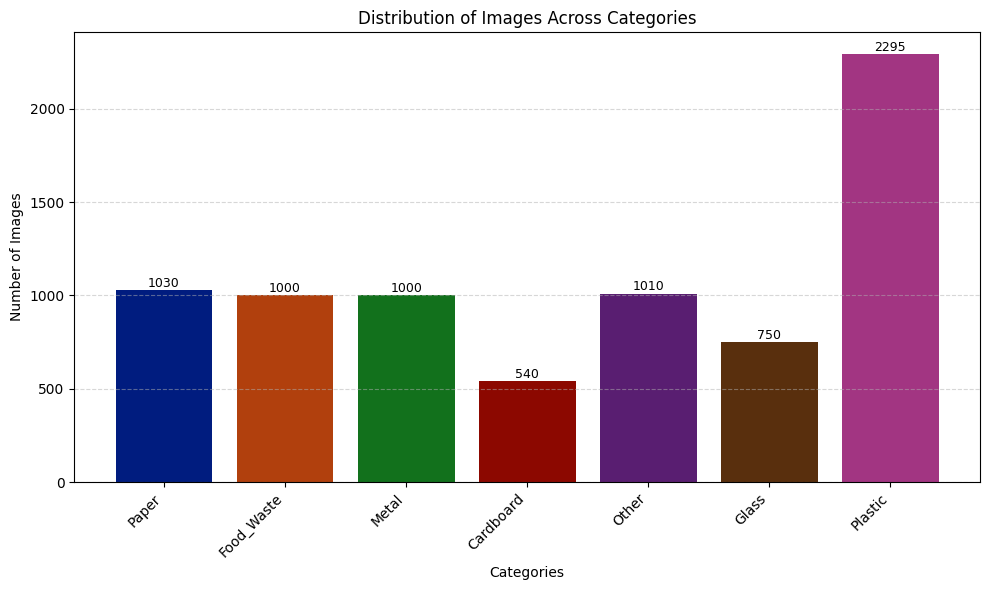

In [6]:

categories = list(category_counts.keys())
counts = list(category_counts.values())


colors = sns.color_palette("dark", n_colors=len(categories))


plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts, color=colors)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 1,
             f'{height}', ha='center', va='bottom', fontsize=9)


plt.xlabel("Categories")
plt.ylabel("Number of Images")
plt.title("Distribution of Images Across Categories")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

In [7]:
# Visualise Sample Images (across different labels)


num_samples_per_category = 4
plt.figure(figsize=(len(categories) * 3, num_samples_per_category * 3))

for col, category in enumerate(categories):
    indices = [i for i, label in enumerate(labels) if label == category]
    selected = random.sample(indices, min(num_samples_per_category, len(indices)))

    for row, idx in enumerate(selected):
        ax = plt.subplot(num_samples_per_category, len(categories), row * len(categories) + col + 1)
        ax.imshow(images[idx])
        ax.set_title(f"{category}", fontsize=8)
        ax.axis('off')

        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(10)

plt.tight_layout()
plt.show()


#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [8]:
# Find the smallest and largest image dimensions from the data set

def find_min_max_image_sizes(images):
    if not isinstance(images, np.ndarray) or images.size == 0:
        return (0, 0), (0, 0)

    dimensions = [img.shape[:2] for img in images if isinstance(img, np.ndarray) and img.ndim >= 2]
    
    if not dimensions:
        return (0, 0), (0, 0)

    heights, widths = zip(*dimensions)
    
    min_dims = (min(widths), min(heights))
    max_dims = (max(widths), max(heights))
    
    return min_dims, max_dims

min_dims, max_dims = find_min_max_image_sizes(images)
print(f"Minimum dimensions: {min_dims}")
print(f"Maximum dimensions: {max_dims}")


Minimum dimensions: (256, 256)
Maximum dimensions: (256, 256)


In [9]:
# Resize the image dimensions
def resize_images(image_array, target_size):
    return np.array([np.array(Image.fromarray(image).resize(target_size)) for image in image_array])

target_size = (128, 128)
resized_images = resize_images(images, target_size)

print("Original Image Shape:", images[0].shape)
print("Resized Image Shape:", resized_images[0].shape)

min_dims, max_dims = find_min_max_image_sizes(resized_images)
print(f"Minimum dimensions (resized): {min_dims}")
print(f"Maximum dimensions (resized): {max_dims}")



Original Image Shape: (256, 256, 3)
Resized Image Shape: (128, 128, 3)
Minimum dimensions (resized): (128, 128)
Maximum dimensions (resized): (128, 128)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [10]:
# Encode the labels suitably

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

for label, code in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"Original Label: {label}, Encoded Label: {code}")

num_classes = len(np.unique(encoded_labels))
one_hot_labels = tf.keras.utils.to_categorical(encoded_labels, num_classes)

one_hot_labels

Original Label: Cardboard, Encoded Label: 0
Original Label: Food_Waste, Encoded Label: 1
Original Label: Glass, Encoded Label: 2
Original Label: Metal, Encoded Label: 3
Original Label: Other, Encoded Label: 4
Original Label: Paper, Encoded Label: 5
Original Label: Plastic, Encoded Label: 6


array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [11]:
# Assign specified parts of the dataset to train and validation sets

X_temp, X_test, y_temp, y_test = train_test_split(
    resized_images, one_hot_labels, test_size=0.2, random_state=42, stratify=one_hot_labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15, random_state=42, stratify=y_temp
)

# 3. Print shapes
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")

X_train: (5185, 128, 128, 3), y_train: (5185, 7)
X_val:   (915, 128, 128, 3), y_val:   (915, 7)
X_test:  (1525, 128, 128, 3), y_test:  (1525, 7)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [ ]:
# Build and compile the model

X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

# Compute class weights
y_train_int = np.argmax(y_train, axis=1)
from sklearn.utils.class_weight import compute_class_weight

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)
class_weights = dict(enumerate(class_weights_array))

# Define MobileNetV2-based model
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze feature extractor

inputs = Input(shape=(128, 128, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

Epoch 1/30


/Users/sroutray/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4160 - loss: 1.6075

163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.4166 - loss: 1.6056 - val_accuracy: 0.7104 - val_loss: 0.8299
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6321 - loss: 0.9577

163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.6321 - loss: 0.9576 - val_accuracy: 0.7716 - val_loss: 0.7247
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - accuracy: 0.6856 - loss: 0.8231 - val_accuracy: 0.7683 - val_loss: 0.7067
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7012 - loss: 0.7573

163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.7013 - loss: 0.7573 - val_accuracy: 0.7781 - val_loss: 0.6506
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7335 - loss: 0.7012

163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.7335 - loss: 0.7012 - val_accuracy: 0.7836 - val_loss: 0.6380
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7256 - loss: 0.6600

163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.7256 - loss: 0.6601 - val_accuracy: 0.7945 - val_loss: 0.6034
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.7451 - loss: 0.6316 - val_accuracy: 0.7934 - val_loss: 0.5887
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7669 - loss: 0.5754

163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.7669 - loss: 0.5754 - val_accuracy: 0.8011 - val_loss: 0.6036
Epoch 9/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.7643 - loss: 0.5953 - val_accuracy: 0.7934 - val_loss: 0.5973
Epoch 10/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.7800 - loss: 0.5402 - val_accuracy: 0.7902 - val_loss: 0.6276
Epoch 11/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7850 - loss: 0.5251

163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - accuracy: 0.7849 - loss: 0.5253 - val_accuracy: 0.8055 - val_loss: 0.6002
Epoch 12/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7914 - loss: 0.5011

163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.7914 - loss: 0.5011 - val_accuracy: 0.8175 - val_loss: 0.5748
Epoch 13/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.7915 - loss: 0.5184 - val_accuracy: 0.8142 - val_loss: 0.5932
Epoch 14/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.8045 - loss: 0.4799 - val_accuracy: 0.8153 - val_loss: 0.5758
Epoch 15/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.8168 - loss: 0.4527 - val_accuracy: 0.8131 - val_loss: 0.5614
Epoch 16/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8071 - loss: 0.4546

163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.8071 - loss: 0.4546 - val_accuracy: 0.8186 - val_loss: 0.5517
Epoch 17/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8205 - loss: 0.4519

163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.8205 - loss: 0.4519 - val_accuracy: 0.8328 - val_loss: 0.5456
Epoch 18/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.8191 - loss: 0.4431 - val_accuracy: 0.8208 - val_loss: 0.5411
Epoch 19/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.8169 - loss: 0.4565 - val_accuracy: 0.8186 - val_loss: 0.5615
Epoch 20/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.8251 - loss: 0.4291 - val_accuracy: 0.8251 - val_loss: 0.5412
Epoch 21/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8339 - loss: 0.4116

163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.8339 - loss: 0.4116 - val_accuracy: 0.8339 - val_loss: 0.5609
Epoch 22/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.8326 - loss: 0.4098 - val_accuracy: 0.7760 - val_loss: 0.6824
Epoch 23/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.8160 - loss: 0.4439 - val_accuracy: 0.8240 - val_loss: 0.5588
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8301 - loss: 0.5405
Validation Loss: 0.5411
Validation Accuracy: 0.8208
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
              precision    recall  f1-score   support

   Cardboard       0.87      0.89      0.88        65
  Food_Waste       0.88      0.83      0.85       120
       Glass       0.86      0.73      0.79        90
       Metal       0.84      0.85      0.84       120
       Other       0.77      0.79      0.78       121
       Paper       0.70      0.77      0.73       124
     Plastic       0.85      0.85      0.85       275

    accuracy       

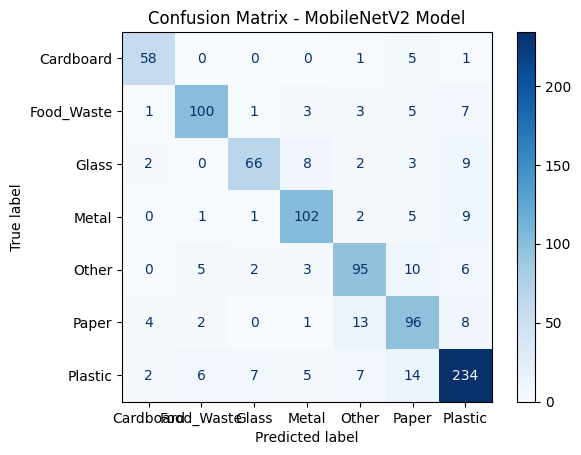

Accuracy: 0.8208
Precision: 0.8226
Recall: 0.8170
F1-score: 0.8187


In [13]:
# Training

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('mobilenet_best.h5', monitor='val_accuracy', save_best_only=True)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stopping, checkpoint]
)

# Evaluate
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Predict and calculate metrics
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - MobileNetV2 Model")
plt.show()

# Additional metrics
acc = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
f1 = f1_score(y_true, y_pred_classes, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")



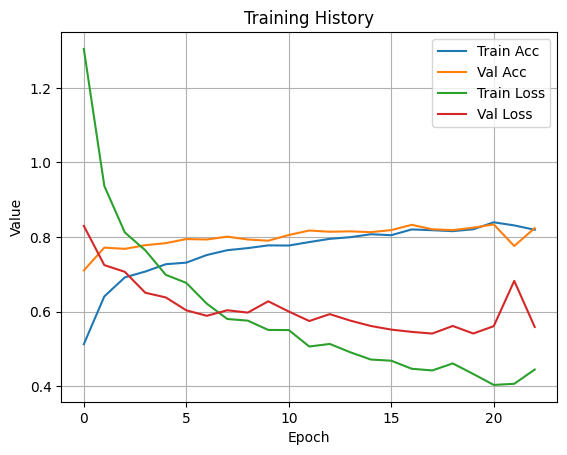

In [14]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.grid(True)
plt.show()

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.8427 - loss: 0.4492
Test Loss: 0.4938
Test Accuracy: 0.8367
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
Classification Report:
              precision    recall  f1-score   support

   Cardboard       0.89      0.91      0.90       108
  Food_Waste       0.91      0.90      0.91       200
       Glass       0.80      0.83      0.82       150
       Metal       0.82      0.90      0.86       200
       Other       0.79      0.80      0.80       202
       Paper       0.76      0.72      0.74       206
     Plastic       0.87      0.83      0.85       459

    accuracy                           0.84      1525
   macro avg       0.83      0.84      0.84      1525
weighted avg       0.84      0.84      0.84      1525



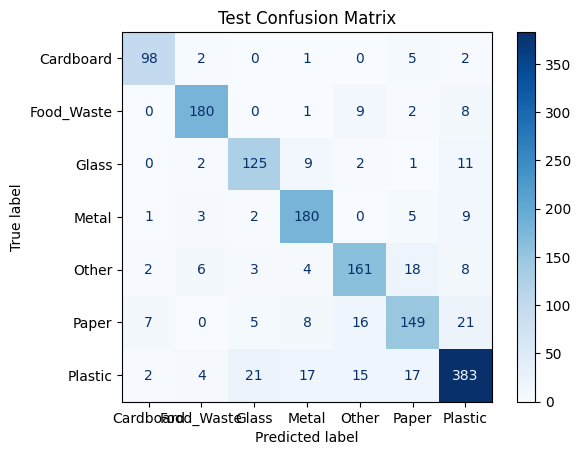

Accuracy: 0.8367
Precision: 0.8371
Recall: 0.8367
F1-score: 0.8365


In [15]:
# Evaluate on the test set; display suitable metrics

# Preprocess test data
X_test = X_test.astype('float32') / 255.0

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred_classes)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_).plot(cmap=plt.cm.Blues)
plt.title("Test Confusion Matrix")
plt.show()

# Summary scores
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [16]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [17]:
# Create a function to augment the images




In [18]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [19]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

## Findings about the data

#### Dataset Composition:
 - The dataset consits of images from 7 different categories, namely `Cardboard`, `Food_Waste`, `Glass`, `Metal`, `Paper`,   `Plastic` and `Other`.
 - Each class is represented by a folder containing images of Objects belonging to each category.

### Class Distribution:
 - The dataset has an imbalanced distribution of images across the classes as observed from the bar plot of class distribution.
 - `Plastic` has siginificantly more images(2295) than other categories, `Cardboard` has very low images(540).
 - This might affect model performance.

### Image Characterristics:
 - Images in data set are prest in `.png` format.
 - Resize operation was performed to standardize all images to 128x128 pixels size.

### Label Encoding:
 - Lables were extracted from folder names and encoded into numerical values.
 - One-hot encoding was applied to prepare the labels for model traning.

### Data Splitting:
 - Dataset was split into training & validation sets using 80:20, ensuring the stratification to maintain class distribution in both sets.

### Potential Issues:
 - Dataset contains class imbalance, which may require techniques like data augumentation or class weighting to improve model performance.
 - Some images have overlapping feature between classes, making classification more chaleenging.




### SUMMARY ###
**TRAING Summary**

- Transfer learning with MobileNetV2 (frozen base) + custom classification head (GAP + Dense + Dropout).

1. Accuracy	82.08%	Overall correct predictions
2. Precision	82.26%	Model makes mostly correct predictions per class
3. Recall	81.70%	Model detects most true instances of each class
4. F1-score	81.87%	Balanced performance between precision and recall

- Pretrained MobileNetV2 for rich feature extraction
- GlobalAveragePooling2D to reduce overfitting
- Dropout layers to improve generalization
- Data augmentation for increased diversity
- Class weighting to address imbalance
- EarlyStopping & ModelCheckpoint for robust training

The model has learned to generalize well to unseen validation data with balanced performance across all classes.

**TESTING Summary**

1. Accuracy	83.67%	Model predicted the correct waste class in ~84 out of 100 test samples.
2. Precision	83.71%	When the model predicted a class, it was correct 83.71% of the time.
3. Recall	83.67%	Model successfully identified 83.67% of actual class instances.
4. F1-score	83.65%	Balanced mean of precision and recall; shows strong, consistent performance.

- Consistent performance across training, validation, and test sets (F1 around 82–84%) indicates no major overfitting.
- A high F1-score on the test set means your model is reliable for real-world deployment.
- The precision-recall balance suggests that the model is not biased toward specific classes, despite any imbalance in data.


### Conclusion: ###

This model is performing very well on completely unseen data — with a robust F1-score above 83%. It's production-ready or can be further fine-tuned with minimal tweaks.
